In [1]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px

import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error

In [2]:
climate = pd.read_csv('Datasets/DailyDelhiClimateTrain.csv',index_col='date')
climate = climate.loc[climate.index != '2017-01-01']
climate.index = pd.DatetimeIndex(climate.index)
display(climate.head())
display(climate.info())
display(climate.describe())

,meantemp,humidity,wind_speed,meanpressure
date,,,,
2013-01-01,10.000000,84.500000,0.000000,1015.666667
2013-01-02,7.400000,92.000000,2.980000,1017.800000
2013-01-03,7.166667,87.000000,4.633333,1018.666667
2013-01-04,8.666667,71.333333,1.233333,1017.166667
2013-01-05,6.000000,86.833333,3.700000,1016.500000


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1461 entries, 2013-01-01 to 2016-12-31
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   meantemp      1461 non-null   float64
 1   humidity      1461 non-null   float64
 2   wind_speed    1461 non-null   float64
 3   meanpressure  1461 non-null   float64
dtypes: float64(4)
memory usage: 57.1 KB


None

,meantemp,humidity,wind_speed,meanpressure
count,1461.000000,1461.000000,1461.000000,1461.000000
mean,25.506127,60.744851,6.806865,1011.101197
std,7.339416,16.743928,4.559688,180.293335
min,6.000000,13.428571,0.000000,-3.041667
25%,18.857143,50.375000,3.475000,1001.571429
50%,27.714286,62.625000,6.250000,1008.555556
75%,31.312500,72.125000,9.250000,1014.937500
max,38.714286,98.000000,42.220000,7679.333333


In [3]:
climate_test = pd.read_csv('Datasets/DailyDelhiClimateTest.csv',index_col='date')
climate_test.index = pd.DatetimeIndex(climate_test.index)
display(climate_test.head())
display(climate_test.info())
display(climate_test.describe())

,meantemp,humidity,wind_speed,meanpressure
date,,,,
2017-01-01,15.913043,85.869565,2.743478,59.000000
2017-01-02,18.500000,77.222222,2.894444,1018.277778
2017-01-03,17.111111,81.888889,4.016667,1018.333333
2017-01-04,18.700000,70.050000,4.545000,1015.700000
2017-01-05,18.388889,74.944444,3.300000,1014.333333


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 114 entries, 2017-01-01 to 2017-04-24
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   meantemp      114 non-null    float64
 1   humidity      114 non-null    float64
 2   wind_speed    114 non-null    float64
 3   meanpressure  114 non-null    float64
dtypes: float64(4)
memory usage: 4.5 KB


None

,meantemp,humidity,wind_speed,meanpressure
count,114.000000,114.000000,114.000000,114.000000
mean,21.713079,56.258362,8.143924,1004.035090
std,6.360072,19.068083,3.588049,89.474692
min,11.000000,17.750000,1.387500,59.000000
25%,16.437198,39.625000,5.563542,1007.437500
50%,19.875000,57.750000,8.069444,1012.739316
75%,27.705357,71.902778,10.068750,1016.739583
max,34.500000,95.833333,19.314286,1022.809524


In [4]:
q1 = climate['meanpressure'].quantile(.25)
q3 = climate['meanpressure'].quantile(.75)
IQR = q3-q1
climate.loc[(climate['meanpressure'] < q1 - 1.5*IQR) | (climate['meanpressure'] > q3 + 1.5*IQR),'meanpressure'] = climate['meanpressure'].median()

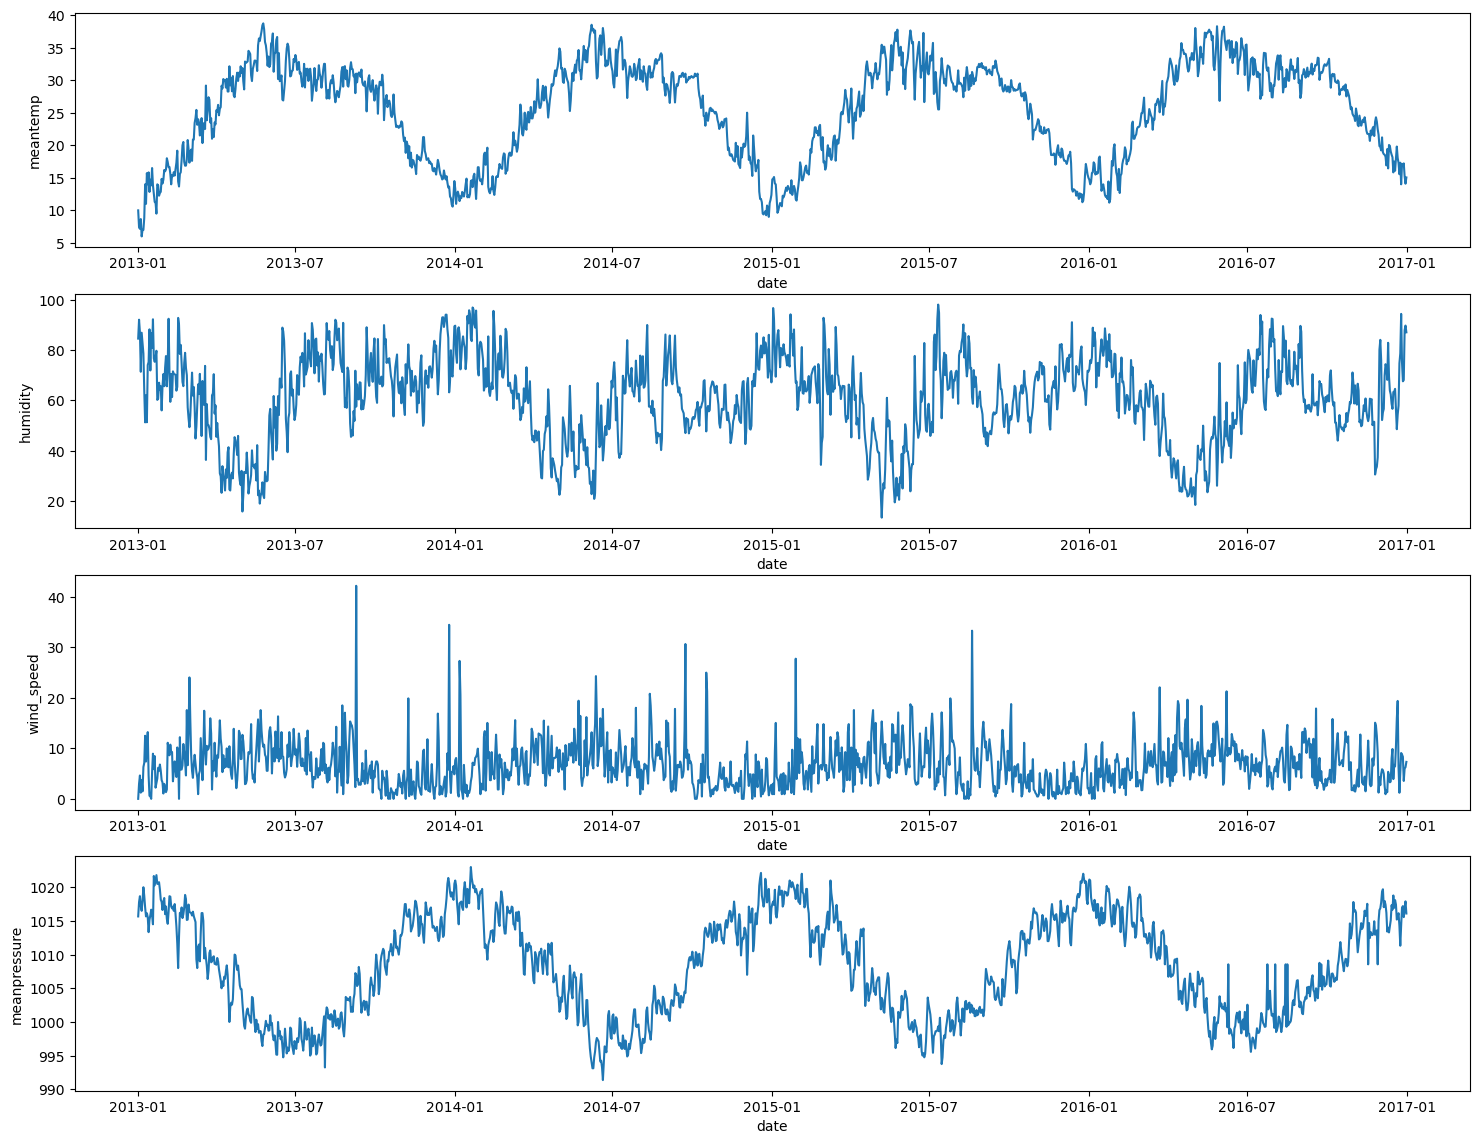

In [5]:
fig, ax = plt.subplots(4,1,figsize=(18,14))
ax = ax.flatten()
for i,col in enumerate(climate.columns):
    sns.lineplot(data=climate,x=climate.index,y=col,ax=ax[i])

# Predicting
## Temperature

In [6]:
X_train = np.column_stack([climate.index.day,climate.index.month,climate.index.year,climate.index.day_of_week,climate.index.day_of_year])
y_train = climate['meantemp']
X_test = np.column_stack([climate_test.index.day,climate_test.index.month,climate_test.index.year,climate_test.index.day_of_week,climate_test.index.day_of_year])
y_test = climate_test['meantemp']

In [7]:
# for model in [xgb.XGBRegressor(),lgb.LGBMRegressor(),CatBoostRegressor(),RandomForestRegressor()]:
#     model.fit(X_train,y_train)
#     y_pred = model.predict(X_test)
#     rmse = mean_squared_error(y_pred,y_test,squared=False)
#     print(f'Model: {str(model)}\nRMSE: {rmse}\n')

In [8]:
# model = lgb.LGBMRegressor(random_state=42)
# param_grid = {
#     'boosting_type': ['gbdt', 'dart', 'goss'], 
#     'num_leaves': range(20, 150),  # Maximum number of leaves in a tree
#     'learning_rate': [0.01, 0.05, 0.1, 0.2],  # Learning rate (controls step size during training)
#     'n_estimators': range(50, 200),  # Number of boosting rounds (trees)
#     'max_depth': range(5, 15),  # Maximum depth of a tree
#     'min_child_samples': range(1, 20),  # Minimum number of samples required to create a leaf node
#     'subsample': [0.8, 0.9, 1.0],  # Fraction of samples used for fitting the trees
#     'colsample_bytree': [0.8, 0.9, 1.0],  # Fraction of features used for fitting the trees
#     'reg_alpha': [0.0, 0.1, 0.5, 1.0],  # L1 regularization term on weights
#     'reg_lambda': [0.0, 0.1, 0.5, 1.0],  # L2 regularization term on weights
#     'min_split_gain': [0.0, 0.1, 0.5, 1.0]  # Minimum loss reduction required to make a further partition on a leaf node
# }

# random_search = RandomizedSearchCV(
#     estimator=model,
#     param_distributions=param_grid,
#     n_iter=10,              # Number of random combinations to try
#     cv=3,                   # Number of cross-validation folds
#     scoring='neg_mean_squared_error',  # Use negative mean squared error as the scoring metric
#     random_state=42         # Random seed for reproducibility
# )
# random_search.fit(X_train, y_train)
# print("Best Hyperparameters:", random_search.best_params_)
# print("Best RMSE:", np.sqrt(-random_search.best_score_))

In [9]:
model = lgb.LGBMRegressor(random_state=42,subsample= 1.0, reg_lambda= 0.0, reg_alpha= 0.1, num_leaves= 98, n_estimators=91, min_split_gain=0.0, 
                          min_child_samples=12, max_depth=7, learning_rate=0.05, colsample_bytree=0.8, boosting_type='goss')
model.fit(X_train,y_train)
y_pred = model.predict(X_test)
print(mean_squared_error(y_pred,y_test,squared=False))

[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000236 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 312
[LightGBM] [Info] Number of data points in the train set: 1461, number of used features: 5
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 25.506127
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

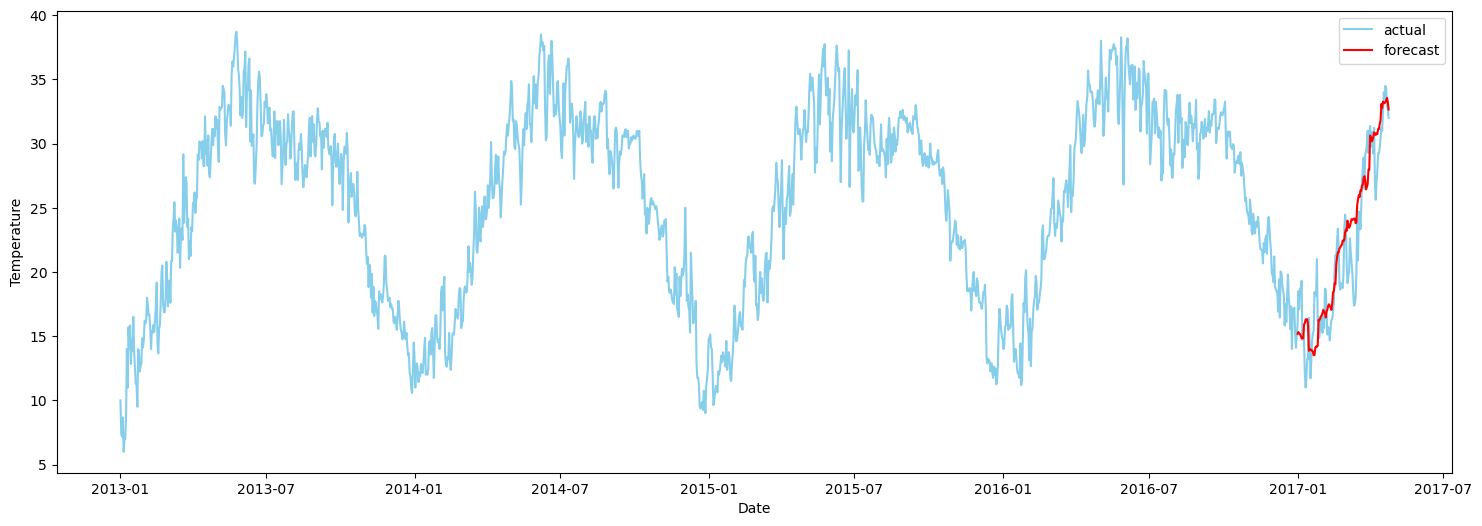

In [10]:
temp_df = pd.concat([climate['meantemp'], climate_test['meantemp']])
pred_df = pd.DataFrame({'date':climate_test.index,'Predicted Temp':y_pred}).set_index('date')

plt.figure(figsize=(18,6))
plt.plot(temp_df,color='skyblue',label='actual')
plt.plot(pred_df,color='red',label='forecast')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.legend()
plt.show()

## Humidity

In [11]:
X_train = np.column_stack([climate.index.day,climate.index.month,climate.index.year,climate.index.day_of_week,climate.index.day_of_year])
y_train = climate['humidity']
X_test = np.column_stack([climate_test.index.day,climate_test.index.month,climate_test.index.year,climate_test.index.day_of_week,climate_test.index.day_of_year])
y_test = climate_test['humidity']

In [12]:
# for model in [xgb.XGBRegressor(),lgb.LGBMRegressor(),CatBoostRegressor(),RandomForestRegressor()]:
#     model.fit(X_train,y_train)
#     y_pred = model.predict(X_test)
#     rmse = mean_squared_error(y_pred,y_test,squared=False)
#     print(f'Model: {str(model)}\nRMSE: {rmse}\n')

In [13]:
# model = CatBoostRegressor(random_state=42)
# param_grid = {
#     'iterations': range(50,501,50),           # Number of boosting iterations (trees)
#     'learning_rate': [0.01, 0.05, 0.1, 0.2],     # Learning rate (step size during training)
#     'depth': range(4,17,2),                    # Depth of the trees
#     'l2_leaf_reg': range(1,10,2),               # L2 regularization term on leaf values
#     'bagging_temperature': [0.0, 0.5, 1.0], # Controls the intensity of Bayesian bagging
#     'random_strength': [0.0, 0.5, 1.0],     # Regularization parameter for randomization
#     'border_count': [32, 64, 128, 256],           # Number of splits for numerical features
#     'subsample': [0.8, 0.9, 1.0],           # Fraction of data used for fitting the trees
#     'rsm': [0.8, 0.9, 1.0]                  # Fraction of features used for fitting the trees
# }

# random_search = RandomizedSearchCV(
#     estimator=model,
#     param_distributions=param_grid,
#     n_iter=10,              # Number of random combinations to try
#     cv=10,                   # Number of cross-validation folds
#     scoring='neg_mean_squared_error',  # Use negative mean squared error as the scoring metric
#     random_state=42         # Random seed for reproducibility
# )
# random_search.fit(X_train, y_train)
# print("Best Hyperparameters:", random_search.best_params_)
# print("Best RMSE:", np.sqrt(-random_search.best_score_))

In [14]:
model = CatBoostRegressor(random_state=42,subsample= 1.0, rsm= 1.0, random_strength= 1.0, loss_function= 'RMSE', 
                          learning_rate= 0.1, l2_leaf_reg= 9, iterations= 150, depth= 12, border_count= 64, bagging_temperature= 0.0)
model.fit(X_train,y_train)
y_pred = model.predict(X_test)
print(mean_squared_error(y_pred,y_test,squared=False))

0:	learn: 15.9499009	total: 62.9ms	remaining: 9.37s
1:	learn: 15.2423395	total: 63.3ms	remaining: 4.68s
2:	learn: 14.6483031	total: 65ms	remaining: 3.18s
3:	learn: 14.1348580	total: 68.4ms	remaining: 2.5s
4:	learn: 13.6997815	total: 71.2ms	remaining: 2.06s
5:	learn: 13.3485449	total: 74.7ms	remaining: 1.79s
6:	learn: 12.8863199	total: 78ms	remaining: 1.59s
7:	learn: 12.4715179	total: 79.2ms	remaining: 1.41s
8:	learn: 12.1561975	total: 80.8ms	remaining: 1.27s
9:	learn: 11.8227941	total: 83.7ms	remaining: 1.17s
10:	learn: 11.4947154	total: 86.2ms	remaining: 1.09s
11:	learn: 11.2532120	total: 87.1ms	remaining: 1s
12:	learn: 11.0261629	total: 87.4ms	remaining: 921ms
13:	learn: 10.8198625	total: 89.8ms	remaining: 873ms
14:	learn: 10.6473446	total: 92.3ms	remaining: 830ms
15:	learn: 10.4490239	total: 94.5ms	remaining: 792ms
16:	learn: 10.2733010	total: 97.4ms	remaining: 762ms
17:	learn: 10.0771033	total: 99.8ms	remaining: 732ms
18:	learn: 9.9032586	total: 102ms	remaining: 704ms
19:	learn: 9.

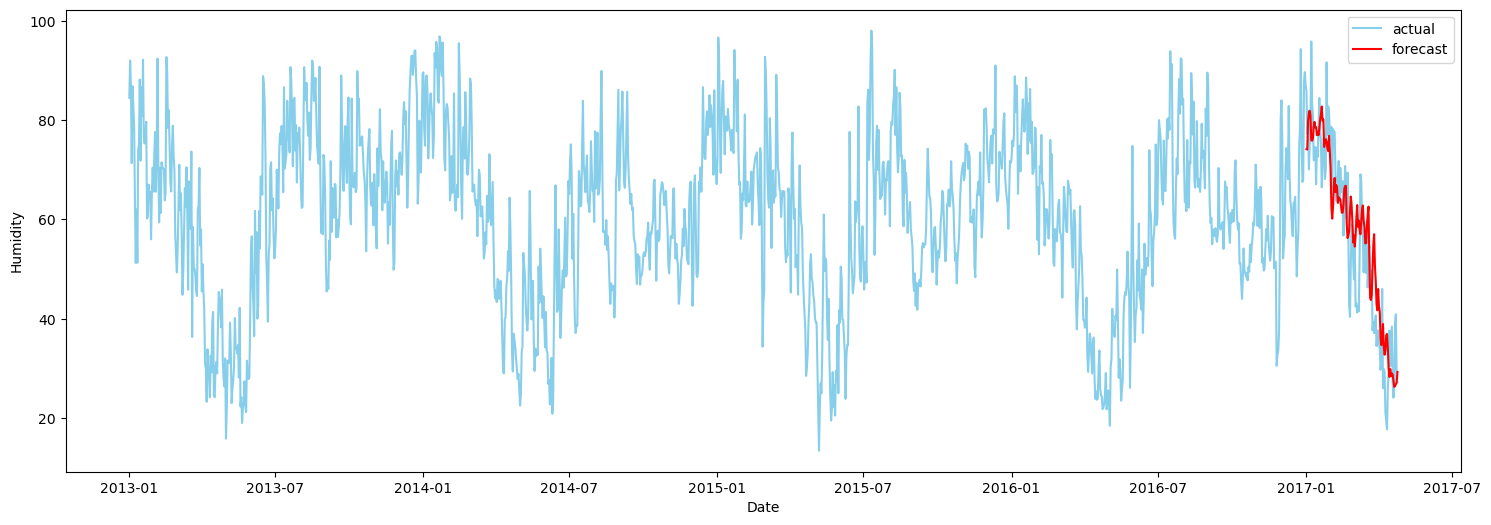

In [15]:
temp_df = pd.concat([climate['humidity'], climate_test['humidity']])
pred_df = pd.DataFrame({'date':climate_test.index,'Predicted Humidity':y_pred}).set_index('date')

plt.figure(figsize=(18,6))
plt.plot(temp_df,color='skyblue',label='actual')
plt.plot(pred_df,color='red',label='forecast')
plt.xlabel('Date')
plt.ylabel('Humidity')
plt.legend()
plt.show()